In [1]:
#https://docs.ray.io/en/latest/train/examples/train_fashion_mnist_example.html

In [2]:
import os
import glob
import random
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.modules.utils import consume_prefix_in_state_dict_if_present
import torch.nn.functional as F
import torchvision
from torchvision.transforms import ToTensor, Resize,Compose, ToPILImage

from sklearn.metrics import classification_report, confusion_matrix

import ray
from ray import train
from ray import tune
import ray.train.torch
from ray.train import Trainer
from ray.train import CheckpointStrategy
from ray.data.datasource import SimpleTorchDatasource

import matplotlib.pyplot as plt

Package pickle5 becomes unnecessary in Python 3.8 and above. Its presence may confuse libraries including Ray. Please uninstall the package.


In [3]:
ray.init('ray://{ray_head}:10001'.format(ray_head=os.environ['RAY_CLUSTER']))

ClientContext(dashboard_url='10.128.2.62:8265', python_version='3.8.12', ray_version='1.13.0', ray_commit='e4ce38d001dbbe09cd21c497fedd03d692b2be3e', protocol_version='2022-03-16', _num_clients=1, _context_to_restore=<ray.util.client._ClientContext object at 0x7f80d426f160>)

In [4]:
transforms = Compose([Resize((64,64)),ToTensor()])

In [5]:
pet_data = torchvision.datasets.OxfordIIITPet("data/",download = True ,  target_types = "category", transform = transforms, split = "trainval")

In [6]:
data_loader = torch.utils.data.DataLoader(pet_data, batch_size=4, shuffle=True)

This data set is only 3K and not the full 7k since we read in dataset with the `split` parameters that pulls in the files based on the corresponding txt file in `data/data/oxford-iiit-pet/annotations`

In [7]:
len(pet_data)

3680

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
device = "cpu"

cpu


Feature batch shape: torch.Size([4, 3, 64, 64])
Labels batch shape: torch.Size([4])


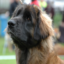

label:19


In [9]:
train_features, train_labels = next(iter(data_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
make = ToPILImage()
make(train_features[0]).show()
print(f'label:{train_labels[0]}')

In [10]:
# modified from https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3,1 )
        
        self.fc1 = nn.Linear(6272 , 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 37)
        
        self.dropout1 = nn.Dropout(0.25)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool((self.conv1(x)))
        x = self.pool((self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        y_pred = self.fc3(x)
        return y_pred



In [11]:
net = ConvNet()
net.to(device)

ConvNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=6272, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=37, bias=True)
  (dropout1): Dropout(p=0.25, inplace=False)
  (relu): ReLU()
)

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [13]:
def train_x(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 1000 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [14]:
%time
for epoch in range(2):
    train_x(net,device,data_loader, optimizer, epoch) 
    
state_dict = net.state_dict()
consume_prefix_in_state_dict_if_present(state_dict, "module.")        

print('Finished Training')

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.72 µs
Train Epoch: 0 [0/3680 (0%)]	Loss: 3.615417
Train Epoch: 1 [0/3680 (0%)]	Loss: 3.608507
Finished Training


In [15]:
model_scripted = torch.jit.script(net)
model_scripted.save('model_scripted.pt')

In [16]:
# Now with Ray 

In [17]:
dataset_factory = lambda: torchvision.datasets.OxfordIIITPet("data/", download = True, target_types = "category", transform = transforms, split = "trainval")
dataset = ray.data.read_datasource(
    SimpleTorchDatasource(), parallelism=1, dataset_factory=dataset_factory
)

Caught schedule exception


In [ ]:
x = dataset.random_shuffle().repartition(2).split(2)
x

In [19]:
train_data = x[0]
test_data = x[1]

In [20]:
def train_epoch(dataloader, model, loss_fn, optim):
    model.train()
    model.to("cuda")
    for batch_idx, data in enumerate(dataloader.iter_batches()):
        X = [x[0] for x in data]
        X = torch.stack(X)
        X = X.to("cuda")
        y = [torch.tensor(x[1]) for x in data]
        y = torch.stack(y)
        y = y.to("cuda") 
        pred = model(X)
        loss = loss_fn(pred, y)
        
        #backprop
        optim.zero_grad()
        loss.backward()
        optim.step()
        
    return loss.item()

In [21]:
def validate_epoch(dataloader, model, loss_fn):
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for data in dataloader.iter_batches():
            X = [x[0] for x in data]
            X = torch.stack(X)
            X = X.to("cuda")
            y = [torch.tensor(x[1]) for x in data]
            y = torch.stack(y)
            y = y.to("cuda")
            pred = model(X)
            test_loss += loss_fn(pred, y).item()  
    
    return test_loss/dataloader.num_blocks()

            

In [22]:
# Define a search space.
search_space = {
    "lr": tune.grid_search([0.001, 0.1]),
    "momentum": tune.grid_search([0.1, 0.9]),
    "batch_size": tune.grid_search([4]), 
    "epochs": tune.grid_search([300]),
    "tune_run": tune.grid_search([True])
    
}

In [23]:
def train_func(config):
    batch_size = config["batch_size"]
    lr = config["lr"]
    epochs = config["epochs"]
    momentum = config["momentum"]
    tune_run = config["tune_run"]
    
    
    train_dataloader = train_data
    test_dataloader = test_data
    model = ConvNet()
    #model = train.torch.prepare_model(model)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr,  momentum=momentum)
    
    loss_results = []
    eval_results = []
    
    for epoch in range(epochs):
        loss = train_epoch(train_dataloader, model, loss_fn, optimizer)
        val_loss = validate_epoch(test_dataloader, model, loss_fn)
        #train.report(loss=val_loss)
        loss_results.append(loss)
        eval_results.append(val_loss)
        if not tune_run:
            if epoch % 100 == 0:
                print(f"epoch:{epoch}  loss {loss:>7f}")
                print(f"eval loss: {val_loss:>7f}")    

            if epoch == epochs-1:
                state_dict = model.state_dict()
                consume_prefix_in_state_dict_if_present(state_dict, "module.")
                train.save_checkpoint(epoch=epochs, model_weights=state_dict)
    
    if tune_run:
        tune.report(loss=loss)
    
    return loss_results, eval_results
            
    

In [24]:
# Tune! 

In [ ]:
analysis = tune.run(tune.with_parameters(train_func), config=search_space, resources_per_trial={'gpu': 1})
print(analysis.get_best_config(metric="loss", mode="min"))

In [26]:
# Now that we know best param, we'll train and save our model. This prevents us from saving N model trails that we'll need to deleted later.  

In [27]:
%%time
if os.environ.get('RAY_CLUSTER') is not None:
    num_workers = 2
else:
    num_workers = 1
    

trainer = Trainer(backend="torch", num_workers=num_workers, use_gpu=True)

2022-08-25 20:04:50,437	INFO trainer.py:243 -- Trainer logs will be logged in: /opt/app-root/src/ray_results/train_2022-08-25_20-04-50


CPU times: user 8.16 ms, sys: 6 µs, total: 8.16 ms
Wall time: 15.7 ms


In [ ]:
%%time
trainer.start()# This keeps starting new workers 

In [29]:
config = analysis.get_best_config(metric="loss", mode="min")
config["tune_run"] = False 

In [ ]:
%%time
loss, eval_ = trainer.run(train_func=train_func,
                          config = config)


In [31]:
results = trainer.latest_checkpoint


In [32]:
%%time
trainer.shutdown()

CPU times: user 1.55 ms, sys: 18 µs, total: 1.57 ms
Wall time: 33.7 ms


2022-08-25 20:08:18,949	INFO common.py:219 -- Exception from actor creation is ignored in destructor. To receive this exception in application code, call a method on the actor reference before its destructor is run.
(BaseWorkerMixin pid=6973) E0825 20:08:18.931918929    7000 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"


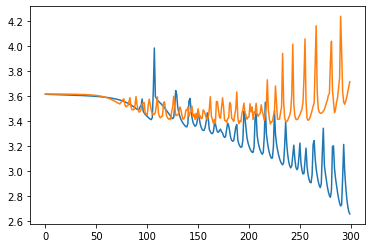

In [33]:
plt.plot(loss[0])
plt.plot(eval_[1])
plt.show()

In [34]:
model = ConvNet()
model.load_state_dict(results["model_weights"])
model_scripted = torch.jit.script(model)
model_scripted.save('models/ray_model_scripted.pt')

In [35]:
model = torch.jit.load("models/ray_model_scripted.pt", map_location=torch.device('cpu')).eval()

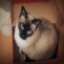

label:32
prediction: 25


In [36]:
train_features, train_labels = next(iter(data_loader))
make = ToPILImage()
make(train_features[0]).show()
print(f'label:{train_labels[0]}')
logits = model(train_features[0].reshape(1,3,64,64).to(device))
print(f"prediction: {torch.argmax(logits).item()}")

In [37]:
y_preds = []
gt = []
for X,y in data_loader:
    logits = model(X[0].reshape(1,3,64,64).to(device))
    y_pred = torch.argmax(logits).item()
    y_preds.append(y_pred)
    gt.append(y[0].item())

In [38]:
for data in test_data.iter_batches():
    X = [x[0] for x in data]
    X = torch.stack(X)
    X = X.to("cpu")
    y = [torch.tensor(x[1]) for x in data]
    y = torch.stack(y)
    logits = model(X.to(device))
    y_preds = torch.argmax(logits, dim=1)
    y_preds = y_preds.to("cpu")

In [39]:
print(classification_report(y_preds,y))

              precision    recall  f1-score   support

           0       0.04      0.06      0.05        31
           1       0.06      0.10      0.07        29
           2       0.00      0.00      0.00        20
           3       0.00      0.00      0.00        12
           4       0.08      0.09      0.08        45
           5       0.02      0.06      0.03        16
           6       0.02      0.07      0.03        14
           7       0.23      0.58      0.33        19
           8       0.11      0.03      0.05       167
           9       0.16      0.06      0.09       113
          10       0.02      0.05      0.03        20
          11       0.00      0.00      0.00         4
          12       0.02      0.09      0.04        11
          13       0.02      0.14      0.03         7
          14       0.06      0.21      0.09        19
          15       0.20      0.20      0.20        50
          16       0.00      0.00      0.00         1
          17       0.04    

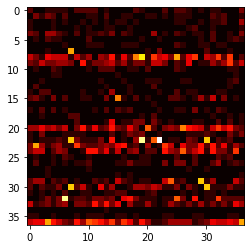

In [40]:
plt.imshow(confusion_matrix(y_preds,y), cmap='hot', interpolation='nearest')
plt.show()

In [41]:
print(f"Accuracy: {np.sum(np.array(y_preds)==np.array(y))/(len(y))*100:.1f}%")
print(f"Random guess would yield {(1/37)*100:.1f}%")
print(f"Model outperforms Random chance by a factor of {(np.sum(np.array(y_preds)==np.array(y))/len(y))/(1/37):.2f}")

Accuracy: 8.1%
Random guess would yield 2.7%
Model outperforms Random chance by a factor of 3.00
